In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar
import torch.nn.functional as F
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [2]:
class VectorQuantizer(nn.Module):
    """
    Reference:
    [1] https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py
    """
    def __init__(self,
                 num_embeddings: int,
                 embedding_dim: int,
                 beta: float = 0.25):
        super(VectorQuantizer, self).__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1 / self.K, 1 / self.K)

    def forward(self, latents: Tensor) -> Tensor:
        latents = latents.permute(0, 2, 3, 1).contiguous()  # [B x D x H x W] -> [B x H x W x D]
        latents_shape = latents.shape
        flat_latents = latents.view(-1, self.D)  # [BHW x D]

        # Compute L2 distance between latents and embedding weights
        dist = torch.sum(flat_latents ** 2, dim=1, keepdim=True) + \
               torch.sum(self.embedding.weight ** 2, dim=1) - \
               2 * torch.matmul(flat_latents, self.embedding.weight.t())  # [BHW x K]

        # Get the encoding that has the min distance
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)  # [BHW, 1]

        # Convert to one-hot encodings
        device = latents.device
        encoding_one_hot = torch.zeros(encoding_inds.size(0), self.K, device=device)
        encoding_one_hot.scatter_(1, encoding_inds, 1)  # [BHW x K]

        # Quantize the latents
        quantized_latents = torch.matmul(encoding_one_hot, self.embedding.weight)  # [BHW, D]
        quantized_latents = quantized_latents.view(latents_shape)  # [B x H x W x D]

        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents, latents.detach())

        vq_loss = commitment_loss * self.beta + embedding_loss

        # Add the residue back to the latents
        quantized_latents = latents + (quantized_latents - latents).detach()

        return quantized_latents.permute(0, 3, 1, 2).contiguous(), vq_loss  # [B x D x H x W]
        

In [3]:
class ResidualLayer(nn.Module):

    def __init__(self,
                 in_channels: int,
                 out_channels: int):
        super(ResidualLayer, self).__init__()
        self.resblock = nn.Sequential(nn.Conv2d(in_channels, out_channels,
                                                kernel_size=3, padding=1, bias=False),
                                      nn.ReLU(True),
                                      nn.Conv2d(out_channels, out_channels,
                                                kernel_size=1, bias=False))

    def forward(self, input: Tensor) -> Tensor:
        return input + self.resblock(input)

In [4]:
class VQVAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 embedding_dim: int,
                 num_embeddings: int,
                 hidden_dims: List = None,
                 beta: float = 0.25,
                 img_size: int = 64,
                 **kwargs) -> None:
        super(VQVAE, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.img_size = img_size
        self.beta = beta

        modules = []
        if hidden_dims is None:
            hidden_dims = [128, 256]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels,
                          kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU())
        )

        for _ in range(6):
            modules.append(ResidualLayer(in_channels, in_channels))
        modules.append(nn.LeakyReLU())

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, embedding_dim,
                          kernel_size=1, stride=1),
                nn.LeakyReLU())
        )

        self.encoder = nn.Sequential(*modules)

        self.vq_layer = VectorQuantizer(num_embeddings,
                                        embedding_dim,
                                        self.beta)

        # Build Decoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(embedding_dim,
                          hidden_dims[-1],
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.LeakyReLU())
        )

        for _ in range(6):
            modules.append(ResidualLayer(hidden_dims[-1], hidden_dims[-1]))

        modules.append(nn.LeakyReLU())

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=4,
                                       stride=2,
                                       padding=1),
                    nn.LeakyReLU())
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1],
                                   out_channels=1,
                                   kernel_size=4,
                                   stride=2, padding=1),
                nn.Tanh(),
                nn.Upsample((28,28)))) # only for MNIST datasets to upsample at size (28, 28)

        self.decoder = nn.Sequential(*modules)

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        return [result]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        result = self.decoder(z)
        return result

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        encoding = self.encode(input)[0]
        quantized_inputs, vq_loss = self.vq_layer(encoding)
        return [self.decode(quantized_inputs), input, vq_loss]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        vq_loss = args[2]

        recons_loss = F.mse_loss(recons, input)

        loss = recons_loss + vq_loss
        return {'loss': loss,
                'Reconstruction_Loss': recons_loss,
                'VQ_Loss':vq_loss}

    def sample(self, num_samples: int, device) -> Tensor:
        raise Warning

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from torchsummary import summary
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize, Compose, ToTensor

vae = VQVAE(1, 28, 100, [16, 64, 128]).to(device)
transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])
dataloader = DataLoader(MNIST(root='./', download=False, transform=transform), batch_size=512)
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3)

In [7]:
from tqdm import tqdm
from torch.cuda.amp import autocast

tqdm_bar=tqdm(range(20))
for ep in tqdm_bar:
    for i, (x, _) in enumerate(dataloader):
        x = x.to(device).float()
        with autocast():
            recon, input, vq_loss=vae(x)
            loss=vae.loss_function(recon, input, vq_loss)
        loss['loss'].backward()
        optimizer.step()
        optimizer.zero_grad()
        if i%10==0:
            tqdm_bar.set_description('loss: {}'.format(loss['loss']))

  0%|          | 0/20 [00:00<?, ?it/s]e:\Anconda3\envs\python\lib\site-packages\torch\amp\autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
loss: 0.39929652214050293: 100%|██████████| 20/20 [34:05<00:00, 102.28s/it]


torch.Size([16, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


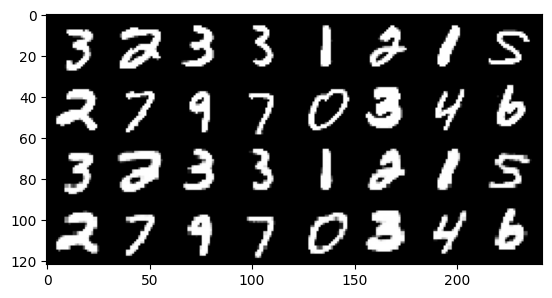

In [10]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
dataloader_test = DataLoader(MNIST(root='./', download=True, transform=transform, train=False), batch_size=16, shuffle=True)
# vae.load_state_dict(torch.load('./vae.pt'))
vae.eval()
for x,_ in dataloader_test:  
    x=x.to(device).float()
    reconstruct_x=vae.generate(x)
    print(reconstruct_x.shape)
    # a = reconstruct_x.permute(1,2,0)
    a = reconstruct_x.cpu().detach().numpy()
    # plt(a)
    # 前两行为输入数字
    # 后两行为重建数字
    new_x=torch.cat([x, reconstruct_x.detach()], dim=0)
    grid_pics=make_grid(new_x.to('cpu'), 8)
    plt.imshow(grid_pics.permute(1,2,0))
    break
